# Introduction

Road transport has been the main choice for inland freight transport within the European Union accounting for 76.30% of the modal share in 2019. Especially in the Netherlands where the port of Rotterdam generates most of the freight activity, the share of road freight is estimated at over 50% in 2019 *(1)*. This reliance on road transport calls for robust and reliable traffic operations. On the one hand, freight transport contributes to congestion and on the other hand, trucking companies in the Netherlands have suffered economic damage due to road congestion. This economic damage is estimated to be 1.5 billion euros for 2019 and this cost has been increasing yearly *(2)*. Therefore, a thorough investigation of on-trip route choices of truck drivers is fundamental to our understanding of how road freight moves which in turn can support the development of advanced traffic and logistics interventions. 

For more information, the reader may refer to:

Sharma, S., Snelder, M., & Van Lint, H. (2019, June). Deriving on-Trip route choices of truck drivers by utilizing Bluetooth data, loop detector data and variable message sign data. In 2019 6th International Conference on Models and Technologies for Intelligent Transportation Systems (MT-ITS) (pp. 1-8). IEEE, doi: [10.1109/MTITS.2019.8883311](https://ieeexplore.ieee.org/document/8883311).

# Data

To analyze the route choice behavior of truck drivers, we consider a diversion node where truck drivers are prompted to make a choice. The study area is located near the port of Rotterdam and it also witnesses high truck percentages. The study area comprises the motorway ring (A20, A15, A16, and A4) surrounding Rotterdam in the Netherlands as shown in the following figure. 

<img src="map-2.png" alt="Drawing" style="width: 500px;"/>

We consider the traffic going from the hinterland (node A) to the port of Rotterdam (node B). Two route choices, marked by path 1 and 2, are considered. 

The dataset includes four attributes.

1. **ITT:** Loop detector data, provided by Regiolab-Delft service, is used to compute instantaneous travel times. MATLAB version R2018a is used to call Regiolab-Delft service. Loop detectors are installed at every 500 m of motorways in the Netherlands. It is assumed that the traffic conditions do not change for every section between the detector locations. Aggregated speed values for every detector location are retrieved every minute. Then for every such section, the instantaneous travel times are calculated from the speed data. For every path, the travel times of individual sections are added. 
2. **TTR:** Travel time reliability of a path. It is computed from historical travel time data of up to previous 10 days. It is computed using a skewness based indicator. This indicator captures the skewness of the day-to-day travel time variabilities. In contrast to other measures of unreliability which are sensitive to extreme events or outliers, it can be interpreted as the likeliness of incurring a very bad travel time (relative to the median). Mathematically, it is defined as the ratio of the difference between the $90^{th}$ and $50^{th}$ percentile and the difference between the $50^{th}$ and $10^{th}$ percentile.
3. **LC:** The lane closures are retrieved from VMS data provided by the Regiolab-Delft service. The lane closures denote a reduction in capacity which could be a proxy for the incidents. This variable is added to test if truck drivers change their routes in response to an incident downstream. At the instant truck drivers reaches the decision node, we select a maximum number of lanes closed along a path in our analysis.
4. **TD:** Travel distance of a path.

The dataset contain the values of these four attributes individually for both the paths 1 and 2. 

In addition, the dataset contains the IDs of truck drivers and the availabilty of paths (PATH_AV) to check how many paths were available to truck drivers at the time of their decision making.

Next, we load the dataset.

In [1]:
import pandas as pd
# Read the data
df = pd.read_csv('truckdata.txt', sep = '\t')

# Display first ten rows
df.head(10)

,ID,PATH1_AV,PATH2_AV,PATH_CHOICE,ITT_1,TTR_1,LC_1,TD_1,ITT_2,TTR_2,LC_2,TD_2
0,1,1,1,2,21.17,1.33,0,27.6,21.09,3.02,0,23.1
1,2,1,1,1,19.19,1.64,0,27.6,17.85,0.85,0,23.1
2,3,1,1,2,17.12,1.12,0,27.6,15.73,0.55,0,23.1
3,3,1,1,2,19.44,0.50,0,27.6,28.06,1.79,0,23.1
4,4,1,1,2,20.83,1.57,0,27.6,17.13,5.36,1,23.1
5,5,1,1,2,25.56,2.77,0,27.6,28.79,2.96,0,23.1
6,6,1,1,2,19.41,1.64,0,27.6,17.89,0.85,0,23.1
7,7,1,1,2,19.21,2.26,0,27.6,16.58,1.65,0,23.1
8,8,1,1,2,17.10,2.34,0,27.6,19.30,0.50,0,23.1
9,9,1,1,2,17.44,1.07,0,27.6,19.31,1.41,0,23.1


In this dataset, attributes have a suffix that denotes their association with a path (1 or 2). 

In [2]:
print('The total number of observations are', df.shape[0])

The total number of observations are 1671


In [3]:
print('The total number of truck drivers captured in the dataset are', df['ID'].nunique())

The total number of truck drivers captured in the dataset are 1419


This shows that some of the truck drivers are observed more than once in the dataset.

Next, we present the descriptive statistics of the dataset.

In [4]:
df.describe()

,ID,PATH1_AV,PATH2_AV,PATH_CHOICE,ITT_1,TTR_1,LC_1,TD_1,ITT_2,TTR_2,LC_2,TD_2
count,1671.000000,1671.0,1671.0,1671.000000,1671.000000,1671.000000,1671.000000,1.671000e+03,1671.000000,1671.000000,1671.000000,1.671000e+03
mean,711.533214,1.0,1.0,1.773788,22.356451,3.917804,0.257929,2.760000e+01,21.190898,4.564458,0.183722,2.310000e+01
std,406.206205,0.0,0.0,0.418503,7.469346,7.465588,0.485621,8.457990e-13,6.185445,7.756732,0.489774,7.285243e-13
min,1.000000,1.0,1.0,1.000000,15.600000,0.180000,0.000000,2.760000e+01,14.550000,0.370000,0.000000,2.310000e+01
25%,361.500000,1.0,1.0,2.000000,17.520000,1.040000,0.000000,2.760000e+01,16.330000,1.080000,0.000000,2.310000e+01
50%,714.000000,1.0,1.0,2.000000,19.970000,1.470000,0.000000,2.760000e+01,19.070000,2.260000,0.000000,2.310000e+01
75%,1061.500000,1.0,1.0,2.000000,24.350000,2.790000,0.000000,2.760000e+01,24.985000,4.640000,0.000000,2.310000e+01
max,1419.000000,1.0,1.0,2.000000,68.060000,40.580000,3.000000,2.760000e+01,57.120000,50.720000,3.000000,2.310000e+01


We can draw some insights.
1. Both paths 1 and 2 were available to truck drivers at the time they had to make a choice.
2. Path 2 is shorter in terms of distance than the path 1.

Next, we look at the distribution of the labels.

In [5]:
df['PATH_CHOICE'].value_counts()

2    1293
1     378
Name: PATH_CHOICE, dtype: int64

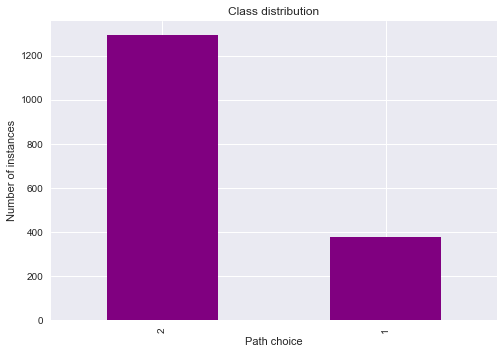

In [6]:
import matplotlib.pyplot as plt
plt.style.use("seaborn")
ax = df['PATH_CHOICE'].value_counts().plot(kind='bar', color='purple')
ax.set_xlabel('Path choice')
ax.set_ylabel('Number of instances')
plt.title('Class distribution');

The plot clearly shows that truck drivers more often have chosen path 2 in this datset. 

Next, we look at the presence of the multicollinearity in the dataset.

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = df[['ITT_1', 'TTR_1', 'LC_1',
       'TD_1', 'ITT_2', 'TTR_2', 'LC_2', 'TD_2']]
vif = pd.DataFrame()
vif["Features"] = X.columns
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif.round(3)

,Features,VIF Factor
0,ITT_1,2.245
1,TTR_1,1.151
2,LC_1,1.085
3,TD_1,0.030
4,ITT_2,1.616
5,TTR_2,1.121
6,LC_2,1.559
7,TD_2,0.085


The variance inflation factors (VIF) for considered attributes are reported in the above table. Since the value of VIF is less than 5, the effect of multicollinearity on the parameter estimates can be ruled out. 

# Model

We use a multinomial logit models to estimate route choice characteristics of truck drivers. For route choice modeling, a multinomial logit (MNL) model (used as binary logit in this paper) is used. The MNL model is a discrete choice model based on random utility theory which assumes that the individual is perfectly rational and selects the alternative with the highest utility. However, the analyst is assumed to have incomplete information; therefore, uncertainty has to be taken into account. Therefore, the utility is modeled as a random variable so as to reflect the uncertainty. The utility $U_{in}$ that an individual $n$ receives from choosing alternative $i$ from the choice set $C_{n}$ is described by the following equation.
    
$$
U_{in} = V_{in} + \epsilon_{in}
$$  
    
where $V_{in}$ is the deterministic part of the utility and $\epsilon_{in}$ is the error term which is independent and identically Gumbel distributed. 
    
The alternative with the highest utility is chosen. The probability that alternative $i$ is chosen by the individual $n$ from choice set $C_{n}$ is given by:
    
$$
P_{in} = Pr (U_{in} \geq U_{jn}, \forall j \in C_{n})
$$
    
$V_{in}$ involves the explanatory variables while distributional assumptions are made on the joint distribution of error terms $\epsilon_{in} = (\epsilon_{1n},...,\epsilon_{jn})$. Therefore, the probability that a given individual $n$ chooses alternative $i$ from the choice set $C_{n}$ is:
    
$$
P_{in} = \frac{e^{V_{in}}}{\displaystyle \sum_{j \in C_{n}} e^{V_{jn}}} \label{eq:MNL}
$$

For this work, the deterministic part of the utility for a driver $n$ towards an alternative $i$ can be expressed as:

$$
V_{in} = B_TD * TD_{in} +  B_TT * ITT_{in} +  B_TTR * TTR_{in} +  B_LC * LC_{in}
$$

where B_TD, B_TT, B_TTR, and B_LC denote coefficients of the attributes related to travel distance, travel time, travel time reliablity and lane closures, respectively. 

 The route choice models are estimated using PandasBiogeme version 3.2.6 (https://biogeme.epfl.ch/index.html). 

In [8]:
import biogeme.version as ver
print(ver.getText())

biogeme 3.2.6 [2021-08-17]
Version entirely written in Python
Home page: http://biogeme.epfl.ch
Submit questions to https://groups.google.com/d/forum/biogeme
Michel Bierlaire, Transport and Mobility Laboratory, Ecole Polytechnique Fédérale de Lausanne (EPFL)



In [9]:
import biogeme.database as db
import biogeme.biogeme as bio
import biogeme.models as models
import biogeme.messaging as msg
from biogeme.expressions import Beta, DefineVariable, bioNormalCdf, \
    Elem, log, bioDraws, PanelLikelihoodTrajectory, MonteCarlo
import biogeme.loglikelihood as ll
import random

database = db.Database('routechoice', df)

# The following statement allows you to use the names of the
# variable as Python variable.
globals().update(database.variables)

# Parameters to be estimated

B_TD = Beta('B_TD',0,-1000,1000,0 )

B_TT = Beta('B_TT',0,-1000,1000,0 )

B_TTR = Beta('B_TTR',0,-1000,1000,0 )

B_LC = Beta('B_LC',0,-1000,1000,0 )


# Utility functions
V1 = B_TD * TD_1 +  B_TT * ITT_1 +  B_TTR * TTR_1 +  B_LC * LC_1

V2 = B_TD * TD_2 +  B_TT * ITT_2 +  B_TTR * TTR_2 +  B_LC * LC_2

# Associate the utlitiy function with the numbering of alternatives

V = {1: V1, 2: V2}

# Availability of the alternative

av = {1: PATH1_AV,  2: PATH2_AV}

# Definition of the model. This is the contribution of each
# observation to the log likelihood function.
logprob = models.loglogit(V, av, PATH_CHOICE)

# Create the Biogeme object
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = '01logit'

# # Calculate the null log likelihood for reporting.
# biogeme.calculateNullLoglikelihood(av)

# Estimate the parameters
results = biogeme.estimate()

After estimating the model, we present general statistics. 

In [10]:
df_results_statistics = pd.DataFrame(results.getGeneralStatistics()).T
df_results_statistics = df_results_statistics.drop([1], axis=1)
df_results_statistics.columns= ['Values']
df_results_statistics = df_results_statistics.astype('float')
df_results_statistics.round(3)

,Values
Number of estimated parameters,4.000
Sample size,1671.000
Excluded observations,0.000
Init log likelihood,-1158.249
Final log likelihood,-867.758
Likelihood ratio test for the init. model,580.981
Rho-square for the init. model,0.251
Rho-square-bar for the init. model,0.247
Akaike Information Criterion,1743.517
Bayesian Information Criterion,1765.201


Now, we print estiamted parameters.

In [11]:
# Get the results in a pandas table
pandasResults = pd.DataFrame(results.getEstimatedParameters())
pandasResults.round(3)

,Value,Std err,t-test,p-value,Rob. Std err,Rob. t-test,Rob. p-value
B_LC,-0.229,0.095,-2.399,0.016,0.097,-2.364,0.018
B_TD,-0.262,0.013,-19.561,0.000,0.013,-19.544,0.000
B_TT,-0.087,0.013,-6.582,0.000,0.014,-6.390,0.000
B_TTR,-0.006,0.006,-0.979,0.328,0.005,-1.097,0.272


The above table presents the estimates of the route choice model. The signs for travel time, travel distance, travel time unreliability, and lane closures are all negative as expected. The estimate of travel time unreliability is found to be insignificant (robust p-value>0.05). The choice data reveal that few truck drivers make the journey between the same origin and destination more than once within a month. Since the notion of travel time unreliability builds upon experiences, the dataset does not have that many truck drivers traveling between the same OD pair more often.  

Truck drivers prefer shorter paths in terms of distance and travel time. Further, they prefer a path with less number of lane closures so as to ensure that they are traveling on a less interrupted roadway. 

# Routing efficiency

The previous section has reported key attributes which truck drivers consider while making on-trip routing decisions. In this section, we assess the efficiency of those routing decisions from a user-centric perspective. A user-centric decision can be defined as the one where truck drivers arrive at a decision node and choose a path with least instantaneous travel time. 

In [12]:
def chosen_time(row):
    if row['PATH_CHOICE'] == 1:
        return row['ITT_1']
    else:
        return row['ITT_2']

def user_efficient (row):
    if min(row['ITT_1'], row['ITT_2']) >= row['chosen_time']:
        return 1
    else:
        return 0

In [13]:
df['chosen_time'] = df.apply(chosen_time, axis=1)
df['user_efficiency'] = df.apply(user_efficient, axis=1)

df_regular = df[(df.LC_1 == 0) & (df.LC_2 == 0)]

df_cong = df.merge(df_regular, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']

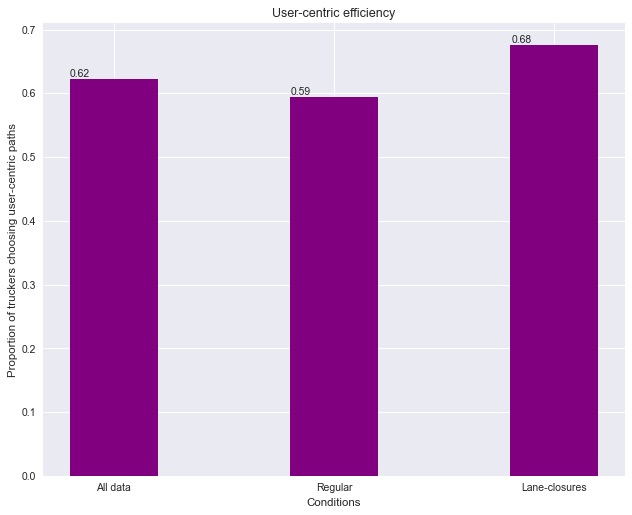

In [14]:
fig, ax = plt.subplots(1, figsize = (10,8),dpi=75)
ax.bar(range(3), [df['user_efficiency'].value_counts(normalize=True)[1],
              df_regular['user_efficiency'].value_counts(normalize=True)[1],
              df_cong['user_efficiency'].value_counts(normalize=True)[1]], color ='purple',
        width = 0.4)

for p in ax.patches:
  ax.annotate(str(p.get_height().round(2)), (p.get_x() * 1.005, p.get_height() * 1.005))

ax.set_xlabel("Conditions")
ax.set_xticks(range(0,3,1))
ax.set_xticklabels( ['All data','Regular', 'Lane-closures'], rotation=0)
ax.set_ylabel("Proportion of truckers choosing user-centric paths")
plt.title("User-centric efficiency")
plt.show()

The above plot shows that 62\% of truck drivers choose the shortest time path. The dataset is further divided into regular conditions (no lane closures on any path) and lane closures on any path. It is observed that truck drivers make more conscious choices when they are informed about the lane closures. 

# Conclusions

We present an on-trip route choice model for truck drivers. The case study for truck-dominated motorways between the port of Rotterdam and hinterland in the Netherlands shows that truck drivers value significantly travel time, travel distance and lane closures en-route. Three out of five truck drivers choose the shortest time path, and this proportion increases if they could distinguish easily the time difference between the alternatives. This analysis is useful for truck-dominated motorways where a large share of traffic consists of trucks. Our analysis suggests that the routing efficiency can be improved by utilizing traffic management solutions. We can guide truck drivers effectively at the decision node. Moreover, dynamic road pricing schemes can be utilized to alter the route choices of truck drivers. 

# References

1. Eurostat. Freight transport statistics - modal split. https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Freight_transport_statistics_-_modal_split. Accessed 09/06/2021, 2021.
2. TLN. Economische Wegwijzer 2020. https://www.tln.nl/app/uploads/2020/11/TLN_EcoWegwijzer_2020_A4_2P_DEF_RGB_HR.pdf. Accessed 07/01/2021, 2021.